## Assignment 3:

The goal is to compare several NLP algorithms for Reuters data – a multi-class classification problem.
 
First, do EDA to understand how many topics (classes) are there in the data. Also understand how many documents
are there in each class. You may want to reduce the number of topics to top 10 or something like that, based
on frequencies.  

In all the experiments, we would hold some parameters constants – truncation of the documents to 10,000 tokens,
 the batch size to 100, the number of epochs to 10, training split at 15%, same optimizer, same loss function of cross entropy, so that the comparisons are fair.
 
* **EXPERIMENT 1: Fully connected dense neural network**
* EXPERIMENT 2: Simple RNN
* EXPERIMENT 3: LSTM RNN
* EXPERIMENT 4: 1D CNN

`Result`:  Create a table with the accuracy and loss for train/test/validation & process time for all the 4 models.

`Note`: You can tweak several parameters such as dropout, embedding etc. to get more insights.

## Import packages needed (and set seed)

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.2.4-tf'

In [2]:
import numpy as np
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# EXPERIMENT 1

We create a `DNN` model with 3 layers for classifying the Reuters dataset. As, we describe below, if we reduce the number of topics to the "top 9" and train and test our model with the smaller set of images with those labels we get significant better performance.

## The Reuters dataset

We will be working with the `Reuters dataset`, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like MNIST and Fashion MNIST, the Reuters dataset comes packaged as part of Keras. 

See https://keras.io/api/datasets/reuters/#load_data-function


"Each newswire is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words"."

In [3]:
# https://keras.io/datasets/#reuters-newswire-topics-classification
from tensorflow.keras.datasets import reuters

voc_size = 10000

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=voc_size)

The argument `num_words=voc_size=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [4]:
len(train_data), len(train_labels), len(test_data), len(test_labels)

(8982, 8982, 2246, 2246)

Each example is a list of integers (word indices):

In [5]:
print(train_data[1]) 

[1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]


In [6]:
max([len(set(lst)) for lst in train_data])

530

In [7]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_newswire

'? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3'

In [8]:
len(decoded_newswire.split()) # number words in the newswire document

56

In [9]:
decoded_newswire.split()[:7]   # first 7 words in the document

['?', 'generale', 'de', 'banque', 'sa', 'lt', '?']

In [10]:
len(train_data[1])  # The list of encodings is the same size as the number of words in the document

56

In [11]:
train_data[1][:7] # The encodings of the first 7 words in the document. Again, 2 = "unknown"

[1, 3267, 699, 3434, 2295, 56, 2]

## Reducing the number of topics

We find that the top 9 most frequent topics in both the training and test data sets are the same. We create smaller training and testing data sets using only data whose labels are in the top 9. However, since the resulting numerical labels are *not contiguous* we would have to use 21 nodes in our output layer (since the largest label is 20) if we use the labels as is. Instead, we relabel so that we can use 9 nodes in our output layer.

In [12]:
from collections import Counter
len(Counter(list(train_labels)).keys()) # There are 46 topics

46

In [13]:
# The ten most common test labels
from collections import Counter
train_label_tuples = \
Counter(list(train_labels)).most_common(10) # if we keep the top nine we get the same training and test labels
train_label_tuples

[(3, 3159),
 (4, 1949),
 (19, 549),
 (16, 444),
 (1, 432),
 (11, 390),
 (20, 269),
 (13, 172),
 (8, 139),
 (10, 124)]

In [14]:
# The ten most common test labels
from collections import Counter
test_label_tuples = \
Counter(list(test_labels)).most_common(10) # if we keep the top 9 we get the same training and test labels
test_label_tuples

[(3, 813),
 (4, 474),
 (19, 133),
 (1, 105),
 (16, 99),
 (11, 83),
 (20, 70),
 (8, 38),
 (13, 37),
 (25, 31)]

In [15]:
# Separate the the labels from their frequencies
topics_train_tpl, train_freq = zip(*Counter(list(train_labels)).most_common(9))
topics_train_tpl

(3, 4, 19, 16, 1, 11, 20, 13, 8)

In [16]:
train_freq

(3159, 1949, 549, 444, 432, 390, 269, 172, 139)

In [17]:
topics_test_tpl, test_freq = zip(*Counter(list(test_labels)).most_common(9))
topics_test_tpl

(3, 4, 19, 1, 16, 11, 20, 8, 13)

In [18]:
sum(test_freq) # number of test values in top 10

1852

In [19]:
sum(train_freq)  # number of training values in top 10

7503

In [20]:
train_data_sm, train_labels_sm = zip(*((x,y) for x,y in zip(train_data,train_labels) if y in topics_train_tpl))

In [21]:
import numpy as np
train_data_sm, train_labels_sm = np.array(train_data_sm), np.array(train_labels_sm)

In [22]:
len(train_data_sm), len(train_labels_sm)  # matches number of training values in top 10

(7503, 7503)

In [23]:
test_data_sm, test_labels_sm = zip(*((x,y) for x,y in zip(test_data,test_labels) if y in topics_test_tpl))

In [24]:
test_data_sm, test_labels_sm = np.array(test_data_sm), np.array(test_labels_sm)

In [25]:
len(test_data_sm), len(test_labels_sm) # matches number of test values in top 10

(1852, 1852)

In [26]:
Counter(train_labels_sm) # another sanity check on the the new smaller set of training labels. See In [13].

Counter({3: 3159,
         4: 1949,
         16: 444,
         19: 549,
         8: 139,
         11: 390,
         1: 432,
         13: 172,
         20: 269})

In [27]:
Counter(test_labels_sm) # another sanity check on the the new smaller set of test labels. See In [14].

Counter({3: 813,
         1: 105,
         4: 474,
         11: 83,
         19: 133,
         8: 38,
         20: 70,
         16: 99,
         13: 37})

### Let's modify the labels to make them sequential.

In [28]:
# first define relabeling function
keys = Counter(test_labels_sm).keys()
conv = dict(zip(sorted(keys),range(0,9)))
conv

{1: 0, 3: 1, 4: 2, 8: 3, 11: 4, 13: 5, 16: 6, 19: 7, 20: 8}

In [29]:
# next create the new labels
train_labels_sm2 = [conv[l] for l in train_labels_sm]
test_labels_sm2 = [conv[l] for l in test_labels_sm]
print(Counter(train_labels_sm2))  # Looks like they were relabeled correctly
print(Counter(test_labels_sm2))   # Looks like they were relabeled correctly

Counter({1: 3159, 2: 1949, 7: 549, 6: 444, 0: 432, 4: 390, 8: 269, 5: 172, 3: 139})
Counter({1: 813, 2: 474, 7: 133, 0: 105, 6: 99, 4: 83, 8: 70, 3: 38, 5: 37})


In [30]:
# https://www.kaggle.com/maximarufo/nlp-classification-reuters-dataset
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

In [31]:
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
{k: idx_to_class[k] for k in list(idx_to_class)[:15]} # get 15 key value pairs

{6: 'copper',
 28: 'livestock',
 25: 'gold',
 19: 'money-fx',
 30: 'ipi',
 11: 'trade',
 0: 'cocoa',
 31: 'iron-steel',
 12: 'reserves',
 26: 'tin',
 37: 'zinc',
 34: 'jobs',
 13: 'ship',
 14: 'cotton',
 23: 'alum'}

In [32]:
# get the dictionary for our smaller data set
idx_to_class_sm = {k:v for k,v in idx_to_class.items() if k in topics_test_tpl}
idx_to_class_sm 

{19: 'money-fx',
 11: 'trade',
 13: 'ship',
 20: 'interest',
 16: 'crude',
 3: 'earn',
 8: 'money-supply',
 4: 'acq',
 1: 'grain'}

In [33]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data_sm[16]])
decoded_newswire

'? standard oil co said a contract has been awarded to lt cbs engineering inc for a drilling and production platform to be installed in ? bank block 826 in the gulf of mexico where standard and mobil corp each own a 40 pct interest standard said its standard oil production co subsidiary will operate the platform which is being designed to produce 15 000 barrels of oil and 50 mln cubic feet of gas daily the platform is now expected to be installed in the summer of 1988 other owners are ? ? corp lt ? with 16 66 pct and lt prudential insurance co of america with 3 34 pct reuter 3'

In [34]:
idx_to_class_sm[train_labels_sm[16]]   # checking the dictionary...topic seems to be right

'crude'

# Experiment 1:  DNN with 2 layers

We build two version of our model--one with 46 output and one with 9 outputs. So we can compare the performance of the model on the original and reduced datasets. We will see that the latter model will outperform the former.

## Preparing the data

We need to vectorize the sequence into numeric tensors that the neural networks can work with.

In [35]:
train_data_sm.shape, test_data_sm.shape, train_data.shape, test_data.shape

((7503,), (1852,), (8982,), (2246,))

In [36]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb
import numpy as np

def vectorize_sequences(sequences, dimension=voc_size):   # one row per one column per word in the vocabulary
    results = np.zeros((len(sequences), dimension))
    
    # Say the the ith sequence = [12, 15, 12, 1], then results[i,squence] = 1 is equivalent to
    # results[12] = 1 (executed twice)
    # results[15] = 1
    # results]1] = 1
    # Consequenlty, the ith row will consist of 1s in columns 1, 12 and 15, and 0s everywhere else
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data for both the original and smaller datasets
train_data_smv = vectorize_sequences(train_data_sm)
train_data_v = vectorize_sequences(train_data)
# Our vectorized test data for both the original and smaller datasets
test_data_smv = vectorize_sequences(test_data_sm)
test_data_v = vectorize_sequences(test_data)

In [37]:
train_data_sm.shape, train_data_smv.shape, test_data_sm.shape, test_data_smv.shape

((7503,), (7503, 10000), (1852,), (1852, 10000))

In [38]:
# summary of the shapes of the training and test data before and after vectorization
train_data.shape, train_data_v.shape, test_data_v.shape, test_data_v.shape

((8982,), (8982, 10000), (2246, 10000), (2246, 10000))

In [39]:
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
from tensorflow.keras.utils import to_categorical

one_hot_train_labels_sm = to_categorical(train_labels_sm2)
one_hot_test_labels_sm = to_categorical(test_labels_sm2)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [40]:
# shape of the training and test labels after (categorical) vectorization
one_hot_train_labels_sm.shape, one_hot_test_labels_sm.shape

((7503, 9), (1852, 9))

## Building our network


This is a topic classification problem where we reduced the orginal number topics from 46 to 9. However, note that the output dimension is 21 since the categorical values are not contiguous 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck".

We settle on two hidden layers of dimensions 64 and 32 respectively. Try experimenting with these values to see the effect on performance.


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# To test the effect of reducing the number of topics from 46 to (effectively) 9.

# This is the model to be used with data from all 46 topics
model_full = Sequential()
model_full.add(Dense(64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model_full.add(Dense(32, activation='relu'))
model_full.add(Dense(46, activation='softmax'))

# This is the model we will use with data from the top 9 topics.
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [43]:
# Compile both models
model_full.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

In the commented code below we set apart 1,000 samples in our training data to use as a validation set. Instead, we set the validation_split (=0.15) when training the model.As an alternative, you can uncomment this code and uncomment: validation_data=(val_data_smv, one_hot_val_labels_sm)).

In [44]:
# val_data_smv = train_data_smv[:1000]
# train_data_smv = train_data_smv[1000:]

# one_hot_val_labels_sm = one_hot_train_labels_sm[:1000]
# one_hot_train_labels_sm = one_hot_train_labels_sm[1000:]

# train_data_v = train_data_v[1000:]

# one_hot_val_labels = one_hot_train_labels[:1000]
# one_hot_train_labels = one_hot_train_labels[1000:]

In [45]:
#val_data_smv.shape, train_data_smv.shape, one_hot_val_labels_sm.shape

In [46]:
#val_data_v.shape, train_data_v.shape, one_hot_val_labels.shape

## Training the model

To get the total training time I used the callback. 

In [47]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

Now let's train both networks for 10 epochs (but without callbacks on the full datasets model):

In [48]:
history_full = model_full.fit(train_data_v,
                    one_hot_train_labels,
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)   

Train on 7634 samples, validate on 1348 samples
Epoch 1/10
7634/7634 [==============================] - 1s 171us/sample - loss: 1.8930 - accuracy: 0.6261 - val_loss: 1.3108 - val_accuracy: 0.7122
Epoch 2/10
7634/7634 [==============================] - 1s 112us/sample - loss: 0.9774 - accuracy: 0.7917 - val_loss: 1.0703 - val_accuracy: 0.7648
Epoch 3/10
7634/7634 [==============================] - 1s 107us/sample - loss: 0.6703 - accuracy: 0.8577 - val_loss: 0.9860 - val_accuracy: 0.7878
Epoch 4/10
7634/7634 [==============================] - 1s 113us/sample - loss: 0.4708 - accuracy: 0.8995 - val_loss: 0.9603 - val_accuracy: 0.7960
Epoch 5/10
7634/7634 [==============================] - 1s 123us/sample - loss: 0.3461 - accuracy: 0.9251 - val_loss: 1.0487 - val_accuracy: 0.7752
Epoch 6/10
7634/7634 [==============================] - 1s 117us/sample - loss: 0.2662 - accuracy: 0.9411 - val_loss: 0.9980 - val_accuracy: 0.7990
Epoch 7/10
7634/7634 [==============================] - 1s 121us

In [49]:
print(f"train_acc: {history_full.history['accuracy'][-1]}, val_acc: {history_full.history['val_accuracy'][-1]}")

train_acc: 0.956903338432312, val_acc: 0.7893174886703491


In [50]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
#                     validation_data=(val_data_smv, one_hot_val_labels_sm))
                    validation_split = 0.15)   # comment out if setting validation_data value.

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 1s 184us/sample - loss: 0.9344 - accuracy: 0.7676 - val_loss: 0.5756 - val_accuracy: 0.8641
Epoch 2/10
6377/6377 [==============================] - 1s 122us/sample - loss: 0.3888 - accuracy: 0.9158 - val_loss: 0.4929 - val_accuracy: 0.8766
Epoch 3/10
6377/6377 [==============================] - 1s 115us/sample - loss: 0.2554 - accuracy: 0.9432 - val_loss: 0.5161 - val_accuracy: 0.8792
Epoch 4/10
6377/6377 [==============================] - 1s 113us/sample - loss: 0.1933 - accuracy: 0.9539 - val_loss: 0.5335 - val_accuracy: 0.8739
Epoch 5/10
6377/6377 [==============================] - 1s 110us/sample - loss: 0.1581 - accuracy: 0.9592 - val_loss: 0.5941 - val_accuracy: 0.8650
Epoch 6/10
6377/6377 [==============================] - 1s 107us/sample - loss: 0.1330 - accuracy: 0.9641 - val_loss: 0.6468 - val_accuracy: 0.8615
Epoch 7/10
6377/6377 [==============================] - 1s 103us

In [51]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

7.403748

In [52]:
print(f"train_acc: {history.history['accuracy'][-1]}, val_acc: {history.history['val_accuracy'][-1]}")

train_acc: 0.9684804677963257, val_acc: 0.8525754809379578


## Testing the model

We test both models and get the runtime of the model classifying 9 topics using callbacks. Again, the model with less classes has better performance.

In [53]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [54]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt])

1852/1852 [==============================] - 0s 107us/sample - loss: 0.7721 - accuracy: 0.8575


In [55]:
# Note the original model evaluating the data with 46 topics performs worse on the test data
test_loss, test_accuracy = model_full.evaluate(test_data_v, one_hot_test_labels)
#print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

2246/2246 [==============================] - 0s 84us/sample - loss: 1.1852 - accuracy: 0.7854


In [56]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.199387

In [57]:
history_dict = history.history
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_dict.keys()

dict_keys(['loss', 'val_loss', 'val_accuracy', 'train_accuracy'])

In [58]:
import pandas as pd
history_df=pd.DataFrame(history_dict)
history_df['test_accuracy'] = test_accuracy
history_df = history_df.iloc[-1:]
history_df.tail()

,loss,val_loss,val_accuracy,train_accuracy,test_accuracy
9,0.095976,0.759006,0.852575,0.96848,0.785396


In [59]:
# This takes a bit of time to execute...
#class_values = ([np.argmax(model.predict(test_data_smv[x].reshape(1,10000))) for x in range(0,1852)])

In [60]:
# from collections import Counter
# Counter(class_values).most_common()

## Saving the performance to a DataFrame

Let us now create the DataFrame with statistics. Note that we only need the last row of history_df.

In [61]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # want the model name to appear first
results_df['test_accuracy'] = test_accuracy
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
9,DNN (2 layers),0.095976,0.759006,0.852575,0.96848,0.785396,7.403748,0.199387


## Plotting the performance 

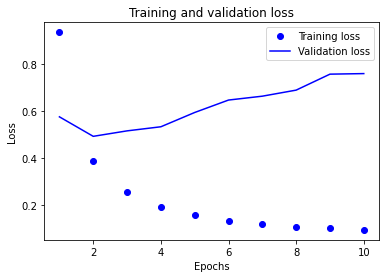

In [62]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

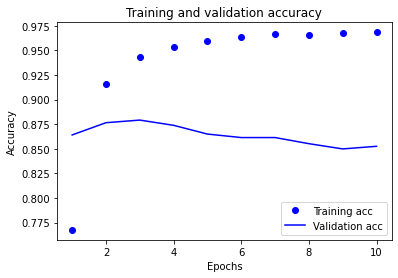

In [63]:
plt.clf()   # clear figure

acc = history.history['train_accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Establishing a baseline
"This approach reaches an accuracy of ~81%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case it’s closer to 26%, so the results seem pretty good, at least when compared to a random baseline:" 

See https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb

In [64]:
import copy

test_labels_sm_copy = copy.copy(test_labels_sm)
np.random.shuffle(test_labels_sm_copy)
float(np.sum(np.array(test_labels_sm) == np.array(test_labels_sm_copy))) / len(test_labels_sm)
# test_labels_copy = copy.copy(test_labels)
# np.random.shuffle(test_labels_copy)
# float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.26187904967602593

## Adding dropout

In [65]:

from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(voc_size,))) # vocabulary size = 10,000
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 297       
Total params: 642,441
Trainable params: 642,441
Non-trainable params: 0
_________________________________________________________________


In [66]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,
                    one_hot_train_labels_sm,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.25)  

Train on 5627 samples, validate on 1876 samples
Epoch 1/10
5627/5627 [==============================] - 1s 200us/sample - loss: 1.0021 - accuracy: 0.7398 - val_loss: 0.6244 - val_accuracy: 0.8555
Epoch 2/10
5627/5627 [==============================] - 1s 119us/sample - loss: 0.4846 - accuracy: 0.8884 - val_loss: 0.5788 - val_accuracy: 0.8609
Epoch 3/10
5627/5627 [==============================] - 1s 124us/sample - loss: 0.3299 - accuracy: 0.9262 - val_loss: 0.5201 - val_accuracy: 0.8790
Epoch 4/10
5627/5627 [==============================] - 1s 127us/sample - loss: 0.2455 - accuracy: 0.9435 - val_loss: 0.5236 - val_accuracy: 0.8833
Epoch 5/10
5627/5627 [==============================] - 1s 123us/sample - loss: 0.1921 - accuracy: 0.9559 - val_loss: 0.5462 - val_accuracy: 0.8742
Epoch 6/10
5627/5627 [==============================] - 1s 130us/sample - loss: 0.1605 - accuracy: 0.9604 - val_loss: 0.6309 - val_accuracy: 0.8593
Epoch 7/10
5627/5627 [==============================] - 1s 125us

In [67]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

7.406006

In [68]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt]) 
#print(f"test_accuracy={test_accuracy}, test_loss={test_loss}")

1852/1852 [==============================] - 0s 83us/sample - loss: 0.7971 - accuracy: 0.8645


In [69]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.154858

## Saving the performance to a DataFrame

Add a row to results_df with the performance statistics.

In [70]:
history_dict = history.history
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers) w Drop') # want the model name to appear first
df['test_accuracy'] = test_accuracy
df['training time (sec)'] = train_time      # we are okay with training time appearing last
df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df = results_df.append(df, ignore_index = True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.095976,0.759006,0.852575,0.968480,0.785396,7.403748,0.199387
1,DNN (2 layers) w Drop,0.101209,0.732633,0.865672,0.969255,0.864471,7.406006,0.154858


## Adding an Embedding layer

Instead of using `vectorize_sequences` to vectorize our input data, we rely on an `Embedding layer` to learn the best vectorization.

In [71]:
train_data_smv.shape

(7503, 10000)

**Since all the input data has to be the same length, we truncate sequences that are too long, i.e. longer than some fixed length maxlen and pad and sequence that are shorter than this. We pick maxlen so that 80% of the sequences have length at most this size.**

In [72]:
train_data_sm_len =[len(w) for w in train_data_sm]
maxlen = int(np.percentile(train_data_sm_len, 80))
f"80th percentile of train_data_sm : {maxlen}"

'80th percentile of train_data_sm : 193'

In [73]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

from tensorflow.keras import preprocessing


train_data_smv = preprocessing.sequence.pad_sequences(train_data_sm, maxlen=maxlen)
test_data_smv = preprocessing.sequence.pad_sequences(test_data_sm, maxlen=maxlen)

In [77]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
from tensorflow.keras.layers import Flatten, Embedding

model = Sequential()

# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 30)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 30)`
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# We add the classifier on top
model.add(Dense(9, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 24704)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 9)                 297       
Total params: 2,863,497
Trainable params: 2,863,497
Non-trainable params: 0
_________________________________________________________________


In [78]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 337us/sample - loss: 1.4045 - accuracy: 0.4681 - val_loss: 1.0487 - val_accuracy: 0.6563
Epoch 2/10
6377/6377 [==============================] - 2s 270us/sample - loss: 0.7795 - accuracy: 0.7648 - val_loss: 0.9075 - val_accuracy: 0.7158
Epoch 3/10
6377/6377 [==============================] - 2s 270us/sample - loss: 0.3844 - accuracy: 0.9081 - val_loss: 0.7274 - val_accuracy: 0.8002
Epoch 4/10
6377/6377 [==============================] - 2s 269us/sample - loss: 0.2140 - accuracy: 0.9514 - val_loss: 0.6856 - val_accuracy: 0.8197
Epoch 5/10
6377/6377 [==============================] - 2s 271us/sample - loss: 0.1457 - accuracy: 0.9617 - val_loss: 0.7973 - val_accuracy: 0.7984
Epoch 6/10
6377/6377 [==============================] - 2s 256us/sample - loss: 0.1003 - accuracy: 0.9647 - val_loss: 0.8414 - val_accuracy: 0.8028
Epoch 7/10
6377/6377 [==============================] - 2s 270us

In [79]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

17.530022

In [80]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt])
test_loss, test_accuracy

1852/1852 [==============================] - 0s 120us/sample - loss: 1.0014 - accuracy: 0.8045


(1.0013535475885378, 0.8045356)

In [81]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.222688

## Plotting the performance 

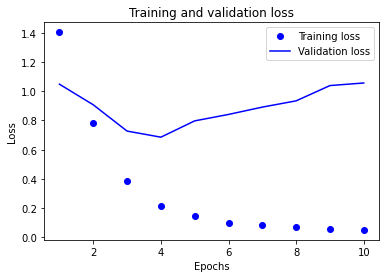

In [82]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

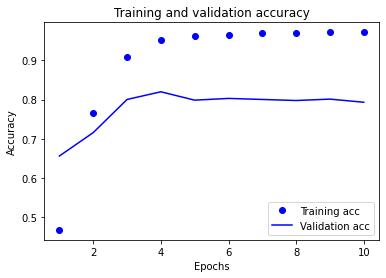

In [83]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Saving the performance to a DataFrame

Add a row to results_df with the performance statistics.

In [85]:
history_dict = history.history.copy()
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers) w Embed') # want the model name to appear first
df['test_accuracy'] = test_accuracy
df['training time (sec)'] = train_time      # we are okay with training time appearing last
df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df = results_df.append(df, ignore_index = True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.095976,0.759006,0.852575,0.968480,0.785396,7.403748,0.199387
1,DNN (2 layers) w Drop,0.101209,0.732633,0.865672,0.969255,0.864471,7.406006,0.154858
2,DNN (2 layers) w Embed,0.050186,1.056904,0.793073,0.971303,0.804536,17.530022,0.222688


## Adding dropout

In [87]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
from tensorflow.keras.layers import Flatten, Embedding

model = Sequential()
model.add(Embedding(voc_size, 128, input_length = maxlen))  # vocabulary size = 10,000
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 24704)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                1581120   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 9)                

In [88]:
train_rt = TrainRuntimeCallback()
history = model.fit(train_data_smv,             
                    one_hot_train_labels_sm,  
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=100,
                    validation_split = 0.15)

Train on 6377 samples, validate on 1126 samples
Epoch 1/10
6377/6377 [==============================] - 2s 336us/sample - loss: 1.5145 - accuracy: 0.4607 - val_loss: 1.0599 - val_accuracy: 0.6297
Epoch 2/10
6377/6377 [==============================] - 2s 260us/sample - loss: 0.9005 - accuracy: 0.7039 - val_loss: 0.8250 - val_accuracy: 0.7256
Epoch 3/10
6377/6377 [==============================] - 2s 268us/sample - loss: 0.5335 - accuracy: 0.8462 - val_loss: 0.7237 - val_accuracy: 0.7984
Epoch 4/10
6377/6377 [==============================] - 2s 293us/sample - loss: 0.3227 - accuracy: 0.9252 - val_loss: 0.6595 - val_accuracy: 0.8330
Epoch 5/10
6377/6377 [==============================] - 2s 275us/sample - loss: 0.2120 - accuracy: 0.9497 - val_loss: 0.7358 - val_accuracy: 0.8215
Epoch 6/10
6377/6377 [==============================] - 2s 268us/sample - loss: 0.1499 - accuracy: 0.9610 - val_loss: 0.7796 - val_accuracy: 0.8233
Epoch 7/10
6377/6377 [==============================] - 2s 280us

In [89]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

17.820075

In [90]:
test_rt = TestRuntimeCallback()
test_loss, test_accuracy = model.evaluate(test_data_smv, one_hot_test_labels_sm, callbacks=[test_rt])
test_loss, test_accuracy

1852/1852 [==============================] - 0s 101us/sample - loss: 1.0215 - accuracy: 0.8197


(1.0214624515619957, 0.8196544)

In [91]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.187404

## Plotting the performance 

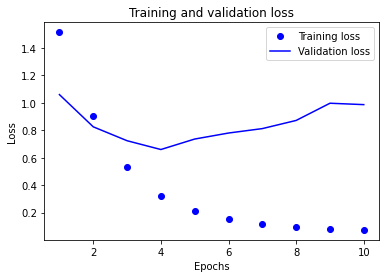

In [92]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

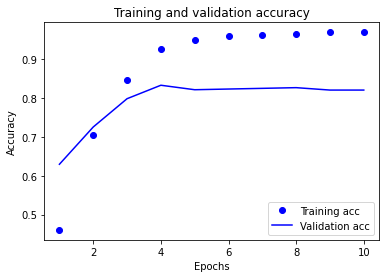

In [93]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Saving the performance to a DataFrame

Add a row to results_df with the performance statistics.

In [94]:
history_dict = history.history.copy()
history_dict['train_accuracy'] = history_dict.pop('accuracy') # rename the the key to 'test_accuracy'
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layers) w Embed + Dropout') # want the model name to appear first
df['test_accuracy'] = test_accuracy
df['training time (sec)'] = train_time      # we are okay with training time appearing last
df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df = results_df.append(df, ignore_index = True)
results_df

,model,loss,val_loss,val_accuracy,train_accuracy,test_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.095976,0.759006,0.852575,0.968480,0.785396,7.403748,0.199387
1,DNN (2 layers) w Drop,0.101209,0.732633,0.865672,0.969255,0.864471,7.406006,0.154858
2,DNN (2 layers) w Embed,0.050186,1.056904,0.793073,0.971303,0.804536,17.530022,0.222688
3,DNN (2 layers) w Embed + Dropout,0.073270,0.986761,0.820604,0.969265,0.819654,17.820075,0.187404


## Saving to a DataFrame to disk

Save the DataFrame for use in part 2.

In [95]:
results_df.to_pickle("results1.pkl") 